# Assignment 2b Notebook: Automated Design of AI Agents with Genetic Programming
This notebook will guide you through the process of implementing genetic programming (GP). This assignment will utilize components you implemented previously during Assignment Series 1, as well as the parse trees you implemented during Assignment 2a. From your previous assignments, copy over the most recent versions of the following files:

* `base_evolution.py`
* `fitness.py`
* `selection.py`
* `tree_genotype.py`

**If you implemented your parse trees in a separate file, copy that file over as well.** In addition, you will need to import this file in the following code cell.

If you receive any feedback about the implementation of your algorithm in 2a, please address any problems before you conduct your experiment for 2b. You may also copy your previous notebooks over if you wish, but be careful to not overwrite the other files in the repo, as we may have made modifications to them.

Recall that you should be launching this notebook using the `EC-env` conda environment. If you are not in the `EC-env` environment, terminate the notebook server, activate the environment with `conda activate EC-env`, and restart the notebook server.

As usual, **be sure to read all of this notebook.** Start by executing the next cell.

In [79]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0
plt.rcParams['animation.embed_limit'] = 2048

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

import os
import statistics
from IPython.display import display, HTML
from pathlib import Path
from scipy import stats
from snake_eyes import read_config
from fitness import play_GPac
from gpac import render_game
from genetic_programming import GeneticProgrammingPopulation
from gpac_population_evaluation import base_population_evaluation
from tree_genotype import *
from selection import *
from histogram import *

print('The first cell has been executed!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## Recombination
Assuming you've correctly implemented population initialization in Assignment 2a, we'll begin this assignment by implementing recombination with subtree crossover. Like Assignment Series 1, your recombination method should take a mate as input and recombine the `genes` members of `self` and `mate`, assign the recombined tree to the `genes` member variable of `child`, and then return `child`.

Recall that this assignment series involves a configurable maximum depth, specified in the config files, and this applies to children produced with recombination and mutation. How you do this is up to you, but **you must guarantee that the children your algorithms produce do not go beyond the configured max depth.**

How you implement subtree crossover in practice depends on your implementation of the parse tree genotype and is thus open-ended. Implement the `TreeGenotype.recombine` function in `tree_genotype.py`, then test your implementation by executing the following cell. This cell will use the same tree checker as Assignment 2a to verify that your trees are structurally correct.

In [59]:
config = read_config('configs/2b/green_config.txt', globals(), locals())

# Initialize a population of 100 individuals.
population = TreeGenotype.initialization(100, **config['problem'])

# Perform recombination to make 50 children.
children = list()
for idx in range(0, len(population), 2):
    child = population[idx].recombine(population[idx+1], **config['problem'])
    children.append(child)

# Save the child trees to files.
os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(children):
    with open(f'tree_tests/tree{idx}r.txt', 'w') as f:
        f.write(individual.serialize())

!python tree_check.py tree_tests/tree*r.txt

del config, population, children

tree_tests/tree0r.txt: PASS
tree_tests/tree10r.txt: PASS
tree_tests/tree11r.txt: PASS
tree_tests/tree12r.txt: PASS
tree_tests/tree13r.txt: PASS
tree_tests/tree14r.txt: PASS
tree_tests/tree15r.txt: PASS
tree_tests/tree16r.txt: PASS
tree_tests/tree17r.txt: PASS
tree_tests/tree18r.txt: PASS
tree_tests/tree19r.txt: PASS
tree_tests/tree1r.txt: PASS
tree_tests/tree20r.txt: PASS
tree_tests/tree21r.txt: PASS
tree_tests/tree22r.txt: PASS
tree_tests/tree23r.txt: PASS
tree_tests/tree24r.txt: PASS
tree_tests/tree25r.txt: PASS
tree_tests/tree26r.txt: PASS
tree_tests/tree27r.txt: PASS
tree_tests/tree28r.txt: PASS
tree_tests/tree29r.txt: PASS
tree_tests/tree2r.txt: PASS
tree_tests/tree30r.txt: PASS
tree_tests/tree31r.txt: PASS
tree_tests/tree32r.txt: PASS
tree_tests/tree33r.txt: PASS
tree_tests/tree34r.txt: PASS
tree_tests/tree35r.txt: PASS
tree_tests/tree36r.txt: PASS
tree_tests/tree37r.txt: PASS
tree_tests/tree38r.txt: PASS
tree_tests/tree39r.txt: PASS
tree_tests/tree3r.txt: PASS
tree_tests/tree40r

## Mutation
Using your parse tree genotype, implement mutation in `TreeGenotype.mutate` and test your implementation by executing the next cell. You can use the grow method that you implemented in the previous assignment to grow a new subtree, replacing an existing randomly-selected subtree. This is called *subtree mutation* in GP literature. Note that you should make sure you don't select the root, which would cause you to grow an entirely new tree. And don't forget to enforce max tree depth like in recombination!

You can also implement mutation in a number of other ways. Particularly, *point mutation* is also common in GP literature and is typically regarded as a performant GP mutation method. In context of the trees we're using here, this would be comparable to a random reset for a small number of the primitives in the tree without modifying the tree structure. That is, you could pick some (preferably small) subset of the nodes in a tree, then randomly select a new primitive for each of the selected nodes (but make sure that terminal nodes stay terminal nodes, and nonterminal nodes stay nonterminal nodes).

In [60]:
config = read_config('configs/2b/green_config.txt', globals(), locals())

# Initialize a population of 50 individuals.
population = TreeGenotype.initialization(50, **config['problem'])

# Perform mutation to make 50 children.
children = list()
for idx in range(len(population)):
    child = population[idx].mutate(**config['problem'])
    children.append(child)

# Save the child trees to files.
os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(children):
    with open(f'tree_tests/tree{idx}m.txt', 'w') as f:
        f.write(individual.serialize())

!python tree_check.py tree_tests/tree*m.txt

del config, population, children

tree_tests/tree0m.txt: PASS
tree_tests/tree10m.txt: PASS
tree_tests/tree11m.txt: PASS
tree_tests/tree12m.txt: PASS
tree_tests/tree13m.txt: PASS
tree_tests/tree14m.txt: PASS
tree_tests/tree15m.txt: PASS
tree_tests/tree16m.txt: PASS
tree_tests/tree17m.txt: PASS
tree_tests/tree18m.txt: PASS
tree_tests/tree19m.txt: PASS
tree_tests/tree1m.txt: PASS
tree_tests/tree20m.txt: PASS
tree_tests/tree21m.txt: PASS
tree_tests/tree22m.txt: PASS
tree_tests/tree23m.txt: PASS
tree_tests/tree24m.txt: PASS
tree_tests/tree25m.txt: PASS
tree_tests/tree26m.txt: PASS
tree_tests/tree27m.txt: PASS
tree_tests/tree28m.txt: PASS
tree_tests/tree29m.txt: PASS
tree_tests/tree2m.txt: PASS
tree_tests/tree30m.txt: PASS
tree_tests/tree31m.txt: PASS
tree_tests/tree32m.txt: PASS
tree_tests/tree33m.txt: PASS
tree_tests/tree34m.txt: PASS
tree_tests/tree35m.txt: PASS
tree_tests/tree36m.txt: PASS
tree_tests/tree37m.txt: PASS
tree_tests/tree38m.txt: PASS
tree_tests/tree39m.txt: PASS
tree_tests/tree3m.txt: PASS
tree_tests/tree40m

## Implementing Genetic Programming
By this point, you should have a complete implementation of your genotype and we can turn our attention to implementing the complete GP algorithm.

### Evaluation and Parsimony Pressure
Recall from the lecture and videos by Dr. Koza that tree GP, using the recombination and mutation methods we have implemented here, tends to produce larger and larger trees. Therefore, most GP implementations provide some mechanism to discourage this "bloat".

You will implement a parsimony penalty to discourage your GP from producing unnecessarily large trees (in addition to the depth limit you already have). This parsimony pressure mechanism penalizes the fitness of a solution based on its size. We will apply this using a very similar calculation to the penalty function in Assignment 1c, using the size of the tree rather than a number of constraint violations:

`fitness = base_fitness - size * parsimony_coefficient`

Where `base_fitness` is the solution's fitness according to the fitness function, `size` is some measure of the tree's size, `parsimony_coefficient` is from your config file, and `fitness` is the penalized fitness. The two most obvious metrics of tree size are max depth and node count, but you are encouraged to experiment with different metrics.

Just like Assignment 1c, **it is not meaningful to compare penalized fitness with unpenalized fitness**. We require that you use base fitness for your analysis, and penalized fitness for evolution (which will happen automatically if you store this in the `fitness` member variable, just like in Assignment 1c).

In the file `gpac_population_evaluation.py`, implement the `base_population_evaluation` function that performs fitness evaluations on an input population and assigns the `base_fitness`, parsimony-penalized `fitness`, and `log` members to each individual. Then, test your implementation by executing the following cell. Note the end of the function contains code which will remove the `log` members from all but your best individuals; this is because the logs can take up a tremendous amount of memory, and most of them are unnecessary. This will be important to consider when you write your generational loop (we'll highlight why it's important when we get there).

In [61]:
config = read_config('configs/2b/green_config.txt', globals(), locals())

# Initialize a population.
population = TreeGenotype.initialization(100, **config['problem'])

# Note explicitly initializing to None is unnecessary in general.
# We only do it here to test that you've actually set these values.
for individual in population:
    individual.fitness = None
    individual.base_fitness = None
    individual.log = None

# Calling your function to test things out.
base_population_evaluation(population, **config['fitness_kwargs'], **config['game'])

missing = len([True for individual in population if individual.fitness is None])
base_missing = len([True for individual in population if individual.base_fitness is None])
log_missing = all(individual.log is None for individual in population)

if missing or base_missing or log_missing:
    print('Some individuals had some members left unassigned.')
    print('Make sure you assign all required members to all individuals, then run this cell again.')
    print('Individuals with unassigned (penalized) fitness:', missing)
    print('Individuals with unassigned base fitness:', base_missing)
    print('No individual had a log:', log_missing)

else:
    fitnesses = [individual.fitness for individual in population]
    print('Average fitness of population:', statistics.mean(fitnesses))
    print('Best fitness in population:', max(fitnesses))
    base_fitnesses = [individual.base_fitness for individual in population]
    print('Average unpenalized (base) fitness of population:', statistics.mean(base_fitnesses))
    print('Best unpenalized (base) fitness in population:', max(base_fitnesses))

    best_log = max(population, key=lambda ind:ind.base_fitness).log
    game_log_path = 'example_game.txt'
    with open(game_log_path, 'w') as f:
        [f.write(f'{line}\n') for line in best_log]
    print('The log of the most fit individual was written to', game_log_path)
    
    del fitnesses, base_fitnesses, best_log

del config, population, missing, base_missing, log_missing

Average fitness of population: -49.42207973421927
Best fitness in population: 37.406976744186046
Average unpenalized (base) fitness of population: -27.31207973421927
Best unpenalized (base) fitness in population: 37.906976744186046
The log of the most fit individual was written to example_game.txt


### Child Generation
With fitness evaluation implemented, you can now implement child generation within the `GeneticProgrammingPopulation` class. This class inherits from the `BaseEvolutionPopulation` class you used in Assignment Series 1, and will use the inherited initialization and survival selection methods without modification. The only method that you need to implement, then, is `generate_children`. This will override the same method in the base class.

Recall that, typically, mutation in GP is mutually exclusive with recombination. That is, mutation in GP is usually used to directly produce children by mutating a copy of the parent. Therefore, you need to implement a GP-specific version of `generate_children` in the `GeneticProgrammingPopulation` class, which will override the version you previously implemented. The implementation should be broadly similar, except that you need to decide whether or not an individual should be mutated (rather than recombined) before recombination occurs, and either do one or the other (but not both).

Once complete, test your implementation using the following cell, which will initialize your EA, as well as making one generation of children.

In [64]:
config = read_config('configs/2b/green_config.txt', globals(), locals())
# Hardcode some parameters to make this example faster
config['ea']['mu'] = 100
config['ea']['num_children'] = 100
config['parent_selection_kwargs']['k'] = 5

# Full initialization of your GP population.
example_ea = GeneticProgrammingPopulation(**config['ea'], **config)

# Evaluate the initial population.
base_population_evaluation(example_ea.population, **config['fitness_kwargs'], **config['game'])
example_ea.evaluations = len(example_ea.population)

# Print statements for tutorialization.
print('Number of fitness evaluations:', example_ea.evaluations)
fitnesses = [individual.fitness for individual in example_ea.population]
print('Average fitness of population:', statistics.mean(fitnesses))
print('Best fitness in population:', max(fitnesses))
base_fitnesses = [individual.base_fitness for individual in example_ea.population]
print('Average unpenalized (base) fitness of population:', statistics.mean(base_fitnesses))
print('Best unpenalized (base) fitness in population:', max(base_fitnesses))

# Make a generation of children.
children = example_ea.generate_children()

# Evaluate the children.
base_population_evaluation(children, **config['fitness_kwargs'], **config['game'])
example_ea.evaluations += len(children)

# Print statements for tutorialization.
print('Number of fitness evaluations:', example_ea.evaluations)
child_fitnesses = [individual.fitness for individual in children]
print('Average fitness of children:', statistics.mean(child_fitnesses))
print('Best fitness in children:', max(child_fitnesses))
base_child_fitnesses = [individual.base_fitness for individual in children]
print('Average unpenalized (base) fitness of children:', statistics.mean(base_child_fitnesses))
print('Best unpenalized (base) fitness in children:', max(base_child_fitnesses))

# Print children trees to files.
os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(children):
    with open(f'tree_tests/tree{idx}c.txt', 'w') as f:
        f.write(individual.serialize())

!python tree_check.py tree_tests/tree*c.txt

del config, example_ea, children, fitnesses, base_fitnesses, child_fitnesses, base_child_fitnesses

Number of fitness evaluations: 100
Average fitness of population: -34.68
Best fitness in population: 45.15891472868217
Average unpenalized (base) fitness of population: -24.34
Best unpenalized (base) fitness in population: 45.65891472868217
Number of fitness evaluations: 200
Average fitness of children: -14.649698781838318
Best fitness in children: 56.48449612403101
Average unpenalized (base) fitness of children: -11.359698781838317
Best unpenalized (base) fitness in children: 57.98449612403101
tree_tests/tree0c.txt: PASS
tree_tests/tree10c.txt: PASS
tree_tests/tree11c.txt: PASS
tree_tests/tree12c.txt: PASS
tree_tests/tree13c.txt: PASS
tree_tests/tree14c.txt: PASS
tree_tests/tree15c.txt: PASS
tree_tests/tree16c.txt: PASS
tree_tests/tree17c.txt: PASS
tree_tests/tree18c.txt: PASS
tree_tests/tree19c.txt: PASS
tree_tests/tree1c.txt: PASS
tree_tests/tree20c.txt: PASS
tree_tests/tree21c.txt: PASS
tree_tests/tree22c.txt: PASS
tree_tests/tree23c.txt: PASS
tree_tests/tree24c.txt: PASS
tree_test

## Single Run Experiment
At this point, you should have everything you need to implement a full GP search to evolve GPac controllers! There are few things you need to do for data collection purposes. Most of this should be familiar from things you did in Assignment Series 1:

1. Call `hist.add(individual.fitness)` once on every individual
2. Call `base_hist.add(individual.base_fitness)` once on every individual
3. Return the **global best base-fitness** `TreeGenotype` as `best_solution`
    * It should have all member variables set. This is the **EXTREMELY IMPORTANT** caveat we hinted at earlier: if you're not tracking the **global** best solution, you may run into a bug where the solution has had its `log` member removed. It is absolutely critical that you track this as the best solution your search has *ever* seen, and not just the best individual in the final generation. You should have already been doing that in the past assignments, but in this one you will run into subtle errors that will waste entire hours of computation if you are not careful.
4. Update your EA's `evaluations` member every time you evaluate individuals
5. Return the mean and max **penalized** fitness in the adult population at the end of each generation (including the initial population) as `mean_fit_per_gen` and `max_fit_per_gen`
6. Return the mean and max **base** fitness in the adult population at the end of each generation (including the initial population) as `mean_base_per_gen` and `max_base_per_gen`
7. Return the mean number of nodes in the adult population at the end of each generation (including the initial population) as `mean_size_per_gen`
   * That is, the average number of nodes in your population of trees
9. Return the mean height of the adult population at the end of each generation (including the initial population) as `mean_height_per_gen`
   * Recall that height here is equivalent to maximum depth -- it is the length of the longest path from the root to any terminal
10. Return the cumulative evaluation count at the end of each generation (including the initial population) as `evaluation_counts`

**IMPORTANT NOTE**: If you intend to do the YELLOW deliverable (which is required for 6660 students but bonus for 5660 students), you may wish to read ahead to that section. That deliverable requires you to collect additional data from your GREEN experiment, and collecting that data now will save you from having to run a redundant experiment later.

Now put all the components together and implement a function to conduct a single full run in the next cell.

In [80]:
from math import inf

def gp_run(num_evaluations, config):
    # Initialize a histogram maker for penalized fitness
    hist = PenaltyHistogramMaker()
    
    # Initialize a histogram maker for base fitness
    base_hist = RoundedFitnessHistogramMaker()

    # Starting at -inf is a good way to keep track of the best fitness
    best_base_fitness = -inf

    # Assign your highest BASE fitness TreeGenotype to this variable
    best_solution = None

    # Assign the mean penalized fitness at each generation to this variable
    mean_fit_per_gen = []

    # Assign the max penalized fitness at each generation to this variable
    max_fit_per_gen = []

    # Assign the mean base fitness at each generation to this variable
    mean_base_per_gen = []

    # Assign the max base fitness at each generation to this variable
    max_base_per_gen = []

    # Assign the mean number of nodes at each generation to this variable
    mean_size_per_gen = []

    # Assign the mean height at each generation to this variable
    mean_height_per_gen = []

    # Assign the evaluation count at each generation to this variable
    evaluation_counts = []

    # Initialize the GP object, including an unevaluated population of size mu
    ea = GeneticProgrammingPopulation(**config['ea'], **config)

    # Implement your GP search here using the functionality we demonstrated in the previous cells
    # Using the above ea variable, evaluate the initial population,
    # continually run generations until you have evaluated num_evaluations solutions in total,
    # and collect data as required

    # Evaluate the initial population.
    base_population_evaluation(ea.population, **config['fitness_kwargs'], **config['game'])

    # Add Fitnesses to the HistogramMaker
    # Add Base Fitnesses to the HistogramMaker
    for individual in ea.population:
        hist.add(individual.fitness)
        base_hist.add(individual.base_fitness)
        
    # Update evaluation count
    ea.evaluations = len(ea.population)
    # Append evaluations count
    evaluation_counts.append(ea.evaluations)

    best_base_fit_curr_gen = -inf
    best_base_fit_solution_curr_gen = None

    # Find the solution with the best base_fitness in the initial population
    for individual in ea.population:
        if individual.base_fitness > best_base_fit_curr_gen:
            best_base_fit_curr_gen = individual.base_fitness
            best_base_fit_solution_curr_gen = individual
    
    # Check if the best base_fitness solution of the current generation is the best overall
    # If it is, set best_solution to this solution
    if best_base_fit_curr_gen > best_base_fitness:
        best_base_fitness = best_base_fit_curr_gen
        best_solution = best_base_fit_solution_curr_gen

    base_fitness_curr_generation = [individual.base_fitness for individual in ea.population]
    fitness_curr_generation = [individual.fitness for individual in ea.population]
    size_curr_generation = [individual.genes.size for individual in ea.population]
    height_curr_generation = [individual.genes.height for individual in ea.population]
    
    # Find and append the mean base_fitness of the current generation
    mean_base_fitness_curr_gen = statistics.mean(base_fitness_curr_generation)
    mean_base_per_gen.append(mean_base_fitness_curr_gen)
    # Find and append the max base_fitness of the current generation
    max_base_per_gen.append(best_base_fit_curr_gen)
    # Find and append the mean fitness of the current generation
    mean_fitness_curr_gen = statistics.mean(fitness_curr_generation)
    mean_fit_per_gen.append(mean_fitness_curr_gen)
    # Find and append the max fitness of the current generation
    max_fit_per_gen.append(max(fitness_curr_generation))
    # Find and append the mean size of the individuals in the current generation
    mean_size_curr_gen = statistics.mean(size_curr_generation)
    mean_size_per_gen.append(mean_size_curr_gen)
    # Find and append the mean height of the individuals in the current generation
    mean_height_curr_gen = statistics.mean(height_curr_generation)
    mean_height_per_gen.append(mean_height_curr_gen)

    while ea.evaluations < num_evaluations:

        # Generate children
        children = ea.generate_children()

        # Evaluate the children
        base_population_evaluation(children, **config['fitness_kwargs'], **config['game'])

        # Add Fitnesses to the HistogramMaker
        # Add Base Fitnesses to the HistogramMaker
        for individual in children:
            hist.add(individual.fitness)
            base_hist.add(individual.base_fitness)

        # Update evaluation count
        ea.evaluations += len(children)
        # Append evaluations count
        evaluation_counts.append(ea.evaluations)

        # Add evaluated children to the adult population
        ea.population += children

        # Perform survival selection
        ea.survival()
    
        best_base_fit_curr_gen = -inf
        best_base_fit_solution_curr_gen = None
    
        # Find the solution with the best base_fitness in the current generation
        for individual in ea.population:
            if individual.base_fitness > best_base_fit_curr_gen:
                best_base_fit_curr_gen = individual.base_fitness
                best_base_fit_solution_curr_gen = individual
    
        # Check if the best base_fitness solution of the current generation is the best overall
        # If it is, set best_solution to this solution
        if best_base_fit_curr_gen > best_base_fitness:
            best_base_fitness = best_base_fit_curr_gen
            best_solution = best_base_fit_solution_curr_gen
    
        base_fitness_curr_generation = [individual.base_fitness for individual in ea.population]
        fitness_curr_generation = [individual.fitness for individual in ea.population]
        size_curr_generation = [individual.genes.size for individual in ea.population]
        height_curr_generation = [individual.genes.height for individual in ea.population]
        
        # Find and append the mean base_fitness of the current generation
        mean_base_fitness_curr_gen = statistics.mean(base_fitness_curr_generation)
        mean_base_per_gen.append(mean_base_fitness_curr_gen)
        # Find and append the max base_fitness of the current generation
        max_base_per_gen.append(best_base_fit_curr_gen)
        # Find and append the mean fitness of the current generation
        mean_fitness_curr_gen = statistics.mean(fitness_curr_generation)
        mean_fit_per_gen.append(mean_fitness_curr_gen)
        # Find and append the max fitness of the current generation
        max_fit_per_gen.append(max(fitness_curr_generation))
        # Find and append the mean size of the individuals in the current generation
        mean_size_curr_gen = statistics.mean(size_curr_generation)
        mean_size_per_gen.append(mean_size_curr_gen)
        # Find and append the mean height of the individuals in the current generation
        mean_height_curr_gen = statistics.mean(height_curr_generation)
        mean_height_per_gen.append(mean_height_curr_gen)
        
    
    return best_solution, mean_fit_per_gen, max_fit_per_gen, \
           mean_base_per_gen, max_base_per_gen, \
           mean_size_per_gen, mean_height_per_gen, \
           evaluation_counts, hist, base_hist

Now run the next cell to test your function. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells. We've lowered the evaluation limit to expedite this test, and hardcoded some parameters to make sure your experiment doesn't break with this low eval limit.

Best solution looks like:
+
|/
||/
|||/
||||+
|||||F
|||||F
||||-
|||||F
|||||10.061132638518423
|||+
||||*
|||||W
|||||P
||||-
|||||F
|||||P
||-
|||+
||||RAND
|||||P
|||||P
||||*
|||||W
|||||F
|||-
||||-
|||||W
|||||G
||||RAND
|||||P
|||||G
|*
||RAND
|||-
||||*
|||||P
|||||-10.537136705722649
||||+
|||||F
|||||F
|||RAND
||||/
|||||30.02094786895617
|||||G
||||+
|||||G
|||||29.722675679385574
||-
|||+
||||-
|||||P
|||||P
||||*
|||||26.391194000748705
|||||7.992453161472078
|||RAND
||||/
|||||W
|||||F
||||/
|||||F
|||||F

Best base fitness: 65.96589147286822
Penalized Fitness Histogram:


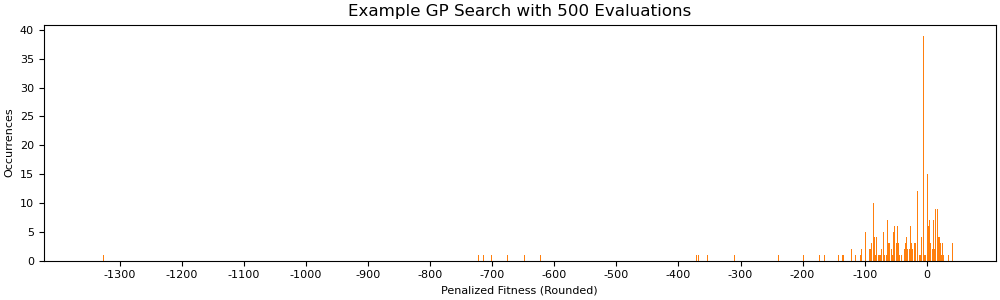

Base Fitness Histogram:


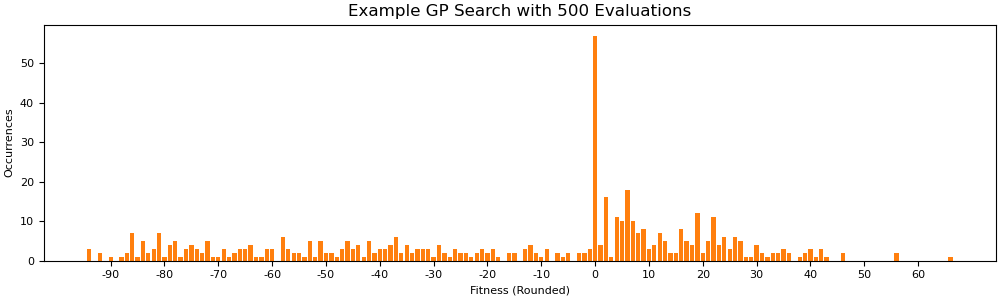

In [41]:
config = read_config('configs/2b/green_config.txt', globals(), locals())
# Hardcode some values to make sure your search doesn't break with the small eval count
config['ea']['mu'] = 100
config['ea']['num_children'] = 50
config['parent_selection_kwargs']['k'] = 2
config['survival_selection_kwargs']['k'] = 2

num_evaluations = 500 # Smaller eval count to make this test quicker

# Call your function
(
    best_solution,
    mean_fit_per_gen,
    max_fit_per_gen,
    mean_base_per_gen,
    max_base_per_gen,
    mean_size_per_gen,
    mean_height_per_gen,
    evaluation_counts,
    hist,
    base_hist
) = gp_run(num_evaluations, config)

print('Best solution looks like:')
print(best_solution.serialize())
print('Best base fitness:', best_solution.base_fitness)

print('Penalized Fitness Histogram:')
hist.get_plot(f'Example GP Search with {num_evaluations} Evaluations').show()
print('Base Fitness Histogram:')
base_hist.get_plot(f'Example GP Search with {num_evaluations} Evaluations').show()

del config, num_evaluations, best_solution, \
           mean_fit_per_gen, max_fit_per_gen, \
           mean_base_per_gen, max_base_per_gen, \
           mean_size_per_gen, mean_height_per_gen, \
           evaluation_counts, hist, base_hist

If your results are dissapointingly bad, don't worry; that's expected. You'll need to tune your algorithm later in order to obtain decent results, and we will walk you through this process later in this notebook.

## Full Experiment
Just like in previous assignments, now that you've implemented a function for a single run, it's time to implement a function for a multi-run experiment. Also similar to those assignments, there's some data collection you need to conduct, all of which should be pretty routine by this point. The data you need to collect this time around is:

1. The highest **base** fitness encountered in each run (one number per run) as `best_per_run`
2. The highest **base** fitness `TreeGenotype` found by any of the runs as `best_solution`
3. The mean and max **penalized** fitness in the adult population at each generation (including the initial population) in each run as `mean_per_gen_per_run` and `max_per_gen_per_run`
4. The mean and max **base** fitness in the adult population at each generation (including the initial population) in each run as `mean_base_per_gen_per_run` and `max_base_per_gen_per_run`
5. The mean number of nodes in the adult population at each generation (including the initial population) in each run as `mean_size_per_gen_per_run`
6. The mean height of the adult population at each generation (including the initial population) in each run as `mean_height_per_gen_per_run`
7. The number of evaluations at the end of each generation (including the initial population) as `evaluation_counts`
8. The two histogram objects representing the data collected from the runs (**this is already done for you!**)

If you implemented data collection in preparation for the YELLOW deliverable, you should also handle that appropriately here.

As with the previous assignments, there are two important things to note about this cell. First, **any time you change a `.py` file, you need to re-execute the following cell** to avoid pickling errors. Second, if you run out of RAM (which typically manifests as your program no longer utilizing the CPU, even though it *looks* like it's still running), you need to pass `processes=x` to the `multiprocessing.Pool` call in order to limit the number of runs that execute in parallel.

In [81]:
from tree_genotype import TreeGenotype
from fitness import play_GPac
from genetic_programming import GeneticProgrammingPopulation
from gpac_population_evaluation import base_population_evaluation

# Returning a TreeGenotype object can cause pickling issues depending on your implementation.
# This just calls your GP run function, and serializes the best solution.
# We instead return this serialized string and the other data, sidestepping the issue.
def multiprocess_helper(num_evaluations, config):
    (
        best_solution,
        mean_fit_per_gen,
        max_fit_per_gen,
        mean_base_per_gen,
        max_base_per_gen,
        mean_size_per_gen,
        mean_height_per_gen,
        evaluation_counts,
        hist,
        base_hist
    ) = gp_run(num_evaluations, config)
    # Copy everything except the genes, and serialize the genes
    serialization = [best_solution, best_solution.serialize()]
    serialization[0].genes = None
    return serialization, mean_fit_per_gen, max_fit_per_gen, \
           mean_base_per_gen, max_base_per_gen, \
           mean_size_per_gen, mean_height_per_gen, \
           evaluation_counts, hist, base_hist


def gp_experiment(num_runs, num_evaluations, config):
    # We handle these for you; don't worry about the histograms here
    hist_per_run = []
    base_hist_per_run = []

    # Assign the highest BASE fitness seen in each run to this variable
    # i.e., a list/tuple of num_runs numbers
    best_per_run = []
    
    # Assign your best TreeGenotype to this variable
    # It should be the highest-base-fitness solution seen across all runs
    best_solution = None
    
    # Use these to store the mean fitness and max fitness at each generation from each run
    # This should be a 2-dimensional data structure, for example:
    # mean_per_gen_per_run[r] is the mean_fit_per_gen returned from run r
    # Therefore:
    # mean_per_gen_per_run[r][g] is the mean fitness from run r at generation g
    mean_per_gen_per_run = []
    max_per_gen_per_run = []

    # These are similar to the above, just using base fitness
    mean_base_per_gen_per_run = []
    max_base_per_gen_per_run = []

    # Similar, but using mean number of nodes
    mean_size_per_gen_per_run = []

    # Similar, but using mean tree height
    mean_height_per_gen_per_run = []

    # Assign the evaluation counts at the end of each generation to this variable
    # Since this should be the same for every run in an experiment, you can just
    # return the evaluation_counts from one of the runs
    evaluation_counts = None
    
    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))


    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i,
        # deserializes its best solution as run_best_solution,
        # and collects the histograms (don't worry about the histograms)
        (
            run_serialization, 
            mean_fit_per_gen,
            max_fit_per_gen,
            mean_base_per_gen,
            max_base_per_gen,
            mean_size_per_gen,
            mean_height_per_gen,
            run_evaluation_counts,
            hist,
            base_hist
        ) = run_results[i]
        run_best_solution = run_serialization[0]
        run_best_solution.deserialize(run_serialization[1])
        hist_per_run.append(hist)
        base_hist_per_run.append(base_hist)

        # TODO: Use run_best_solution,
        #       mean_fit_per_gen, max_fit_per_gen,
        #       mean_base_per_gen, max_base_per_gen,
        #       mean_size_per_gen, mean_height_per_gen,
        #       and run_evaluation_counts
        #       to collect data in the variables described at
        #       the start of this function
        
        
        best_per_run.append(run_best_solution.base_fitness)
        mean_per_gen_per_run.append(mean_fit_per_gen)
        max_per_gen_per_run.append(max_fit_per_gen)
        mean_base_per_gen_per_run.append(mean_base_per_gen)
        max_base_per_gen_per_run.append(max_base_per_gen)
        mean_size_per_gen_per_run.append(mean_size_per_gen)
        mean_height_per_gen_per_run.append(mean_height_per_gen)

        # Checks the solution with the best base_fitness in the run to see if its better than best_solution
        # If it is, sets best_solution to run_best_solution
        if best_solution is None or run_best_solution.base_fitness > best_solution.base_fitness:
            best_solution = run_best_solution

        evaluation_counts = run_evaluation_counts

    # Merge the histograms from each run into one single histogram
    merged_hist = PenaltyHistogramMaker.merge(hist_per_run)
    merged_base_hist = RoundedFitnessHistogramMaker.merge(base_hist_per_run)

    return best_per_run, best_solution, mean_per_gen_per_run, max_per_gen_per_run, \
           mean_base_per_gen_per_run, max_base_per_gen_per_run, \
           mean_size_per_gen_per_run, mean_height_per_gen_per_run, \
           evaluation_counts, merged_hist, merged_base_hist

Let's run a quick test in the next cell to make sure everything works, before we embark on a full experiment. As a reminder, **if you change the previous cell, make sure to re-run that cell to save the changes to your function!** We'll do 3 runs. As with the previous example, we've lowered the evaluation limit and hardcoded some parameters.

Correct number of best fitnesses? True
Best fitness per run: [58.06201550387597, 50.23255813953489, 58.06201550387597]
Best solution looks like:
RAND
|W
|G

Penalized Fitness Histogram:


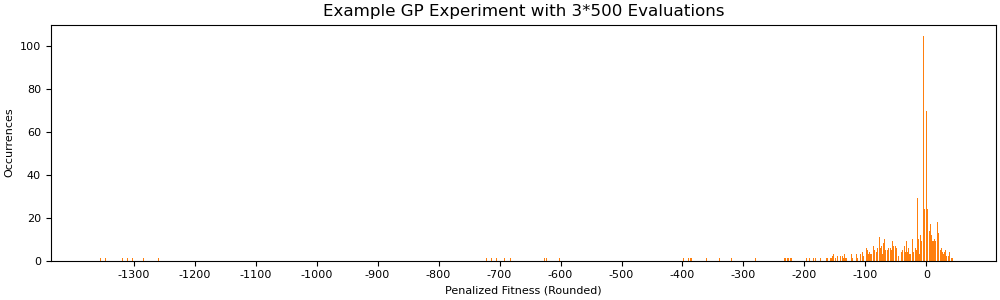

Base Fitness Histogram:


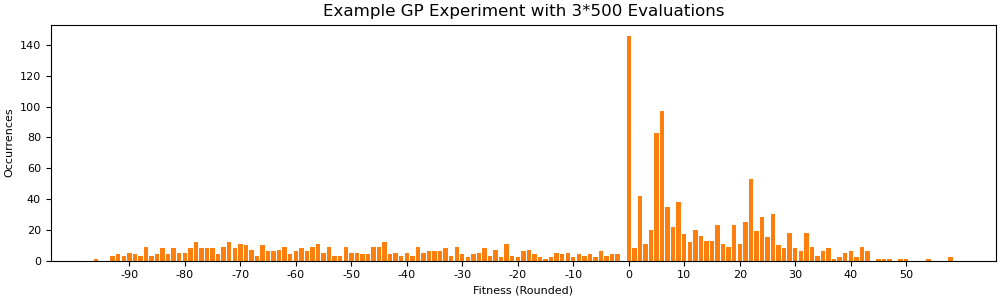

In [43]:
example_config = read_config('configs/2b/green_config.txt', globals(), locals())
# Hardcode some values to make sure your search doesn't break with the small eval count
example_config['ea']['mu'] = 100
example_config['ea']['num_children'] = 50
example_config['parent_selection_kwargs']['k'] = 2
example_config['survival_selection_kwargs']['k'] = 2

example_num_evaluations = 500 # Smaller eval count to make this test quicker
example_num_runs = 3

(
    example_best_per_run,
    example_best_solution,
    example_mean_per_gen_per_run,
    example_max_per_gen_per_run,
    example_mean_base_per_gen_per_run,
    example_max_base_per_gen_per_run,
    example_mean_size_per_gen_per_run,
    example_mean_height_per_gen_per_run,
    example_evaluation_counts,
    example_hist,
    example_base_hist
) = gp_experiment(example_num_runs,
                  example_num_evaluations,
                  example_config)

print('Correct number of best fitnesses?', example_num_runs == len(example_best_per_run))

print('Best fitness per run:', example_best_per_run)
print('Best solution looks like:')
print(example_best_solution.serialize())

print('Penalized Fitness Histogram:')
example_hist_plot = example_hist.get_plot('Example GP Experiment with ' +\
                                          f'{example_num_runs}*{example_num_evaluations} Evaluations')
example_hist_plot.show()

print('Base Fitness Histogram:')
example_base_hist_plot = example_base_hist.get_plot('Example GP Experiment with ' +\
                                          f'{example_num_runs}*{example_num_evaluations} Evaluations')
example_base_hist_plot.show()

Just like in previous assignments, we've provided a function to save your experimental data for you:

In [82]:
def save_data(best_per_run, best_solution, mean_data, max_data, mean_base_data, max_base_data, \
              size_data, height_data, eval_counts, hist, base_hist, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)

    with open(subdir / 'best_per_run.txt', 'w') as f:
        for result in best_per_run:
            f.write(str(result) + '\n')

    with open(subdir / 'best_solution.txt', 'w') as f:
        f.write(best_solution.serialize())

    with open(subdir / 'best_log.txt', 'w') as f:
        for line in best_solution.log:
            f.write(str(line) + '\n')

    with open(subdir / 'mean_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_data))

    with open(subdir / 'max_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_data))

    with open(subdir / 'mean_base_per_gen_per_run.txt', 'w') as f:
        f.write(str(mean_base_data))

    with open(subdir / 'max_base_per_gen_per_run.txt', 'w') as f:
        f.write(str(max_base_data))

    with open(subdir / 'mean_size_per_gen_per_run.txt', 'w') as f:
        f.write(str(size_data))

    with open(subdir / 'mean_height_per_gen_per_run.txt', 'w') as f:
        f.write(str(height_data))

    with open(subdir / 'evaluation_counts.txt', 'w') as f:
        f.write(str(eval_counts))

    hist.save_to_file(subdir / 'histogram.txt')
    base_hist.save_to_file(subdir / 'base_histogram.txt')

    animation = render_game(best_solution.log)
    with open(subdir / 'visualization.html', 'w') as f:
        f.write(animation)
    print('Data saved to', subdir)
    return animation

Run the following cell and navigate to `data/2b/example/` to inspect the results and make sure everything looks correct. Note this function returns the animation object, which is a result of rendering the game.

In [ ]:
animation = save_data(example_best_per_run,
                      example_best_solution,
                      example_mean_per_gen_per_run,
                      example_max_per_gen_per_run,
                      example_mean_base_per_gen_per_run,
                      example_max_base_per_gen_per_run,
                      example_mean_size_per_gen_per_run,
                      example_mean_height_per_gen_per_run,
                      example_evaluation_counts,
                      example_hist,
                      example_base_hist,
                      Path('./data/2b/example/'),
                      example_config)
example_hist_plot.savefig('data/2b/example/histogram.png')
example_base_hist_plot.savefig('data/2b/example/base_histogram.png')
display(HTML(animation))

## Evals-vs-metrics Plot

We ask you to generate an evals-vs-metrics plot similar to the one you've generated in previous assignments. It should plot all of the following metrics versus evaluations:

1. Mean and local max penalized fitness
2. Mean and local max base fitness
3. Mean number of nodes
4. Mean tree height

The code for this should be fairly simple to implement based on what you've done in the past. Here's an example of such a plot:

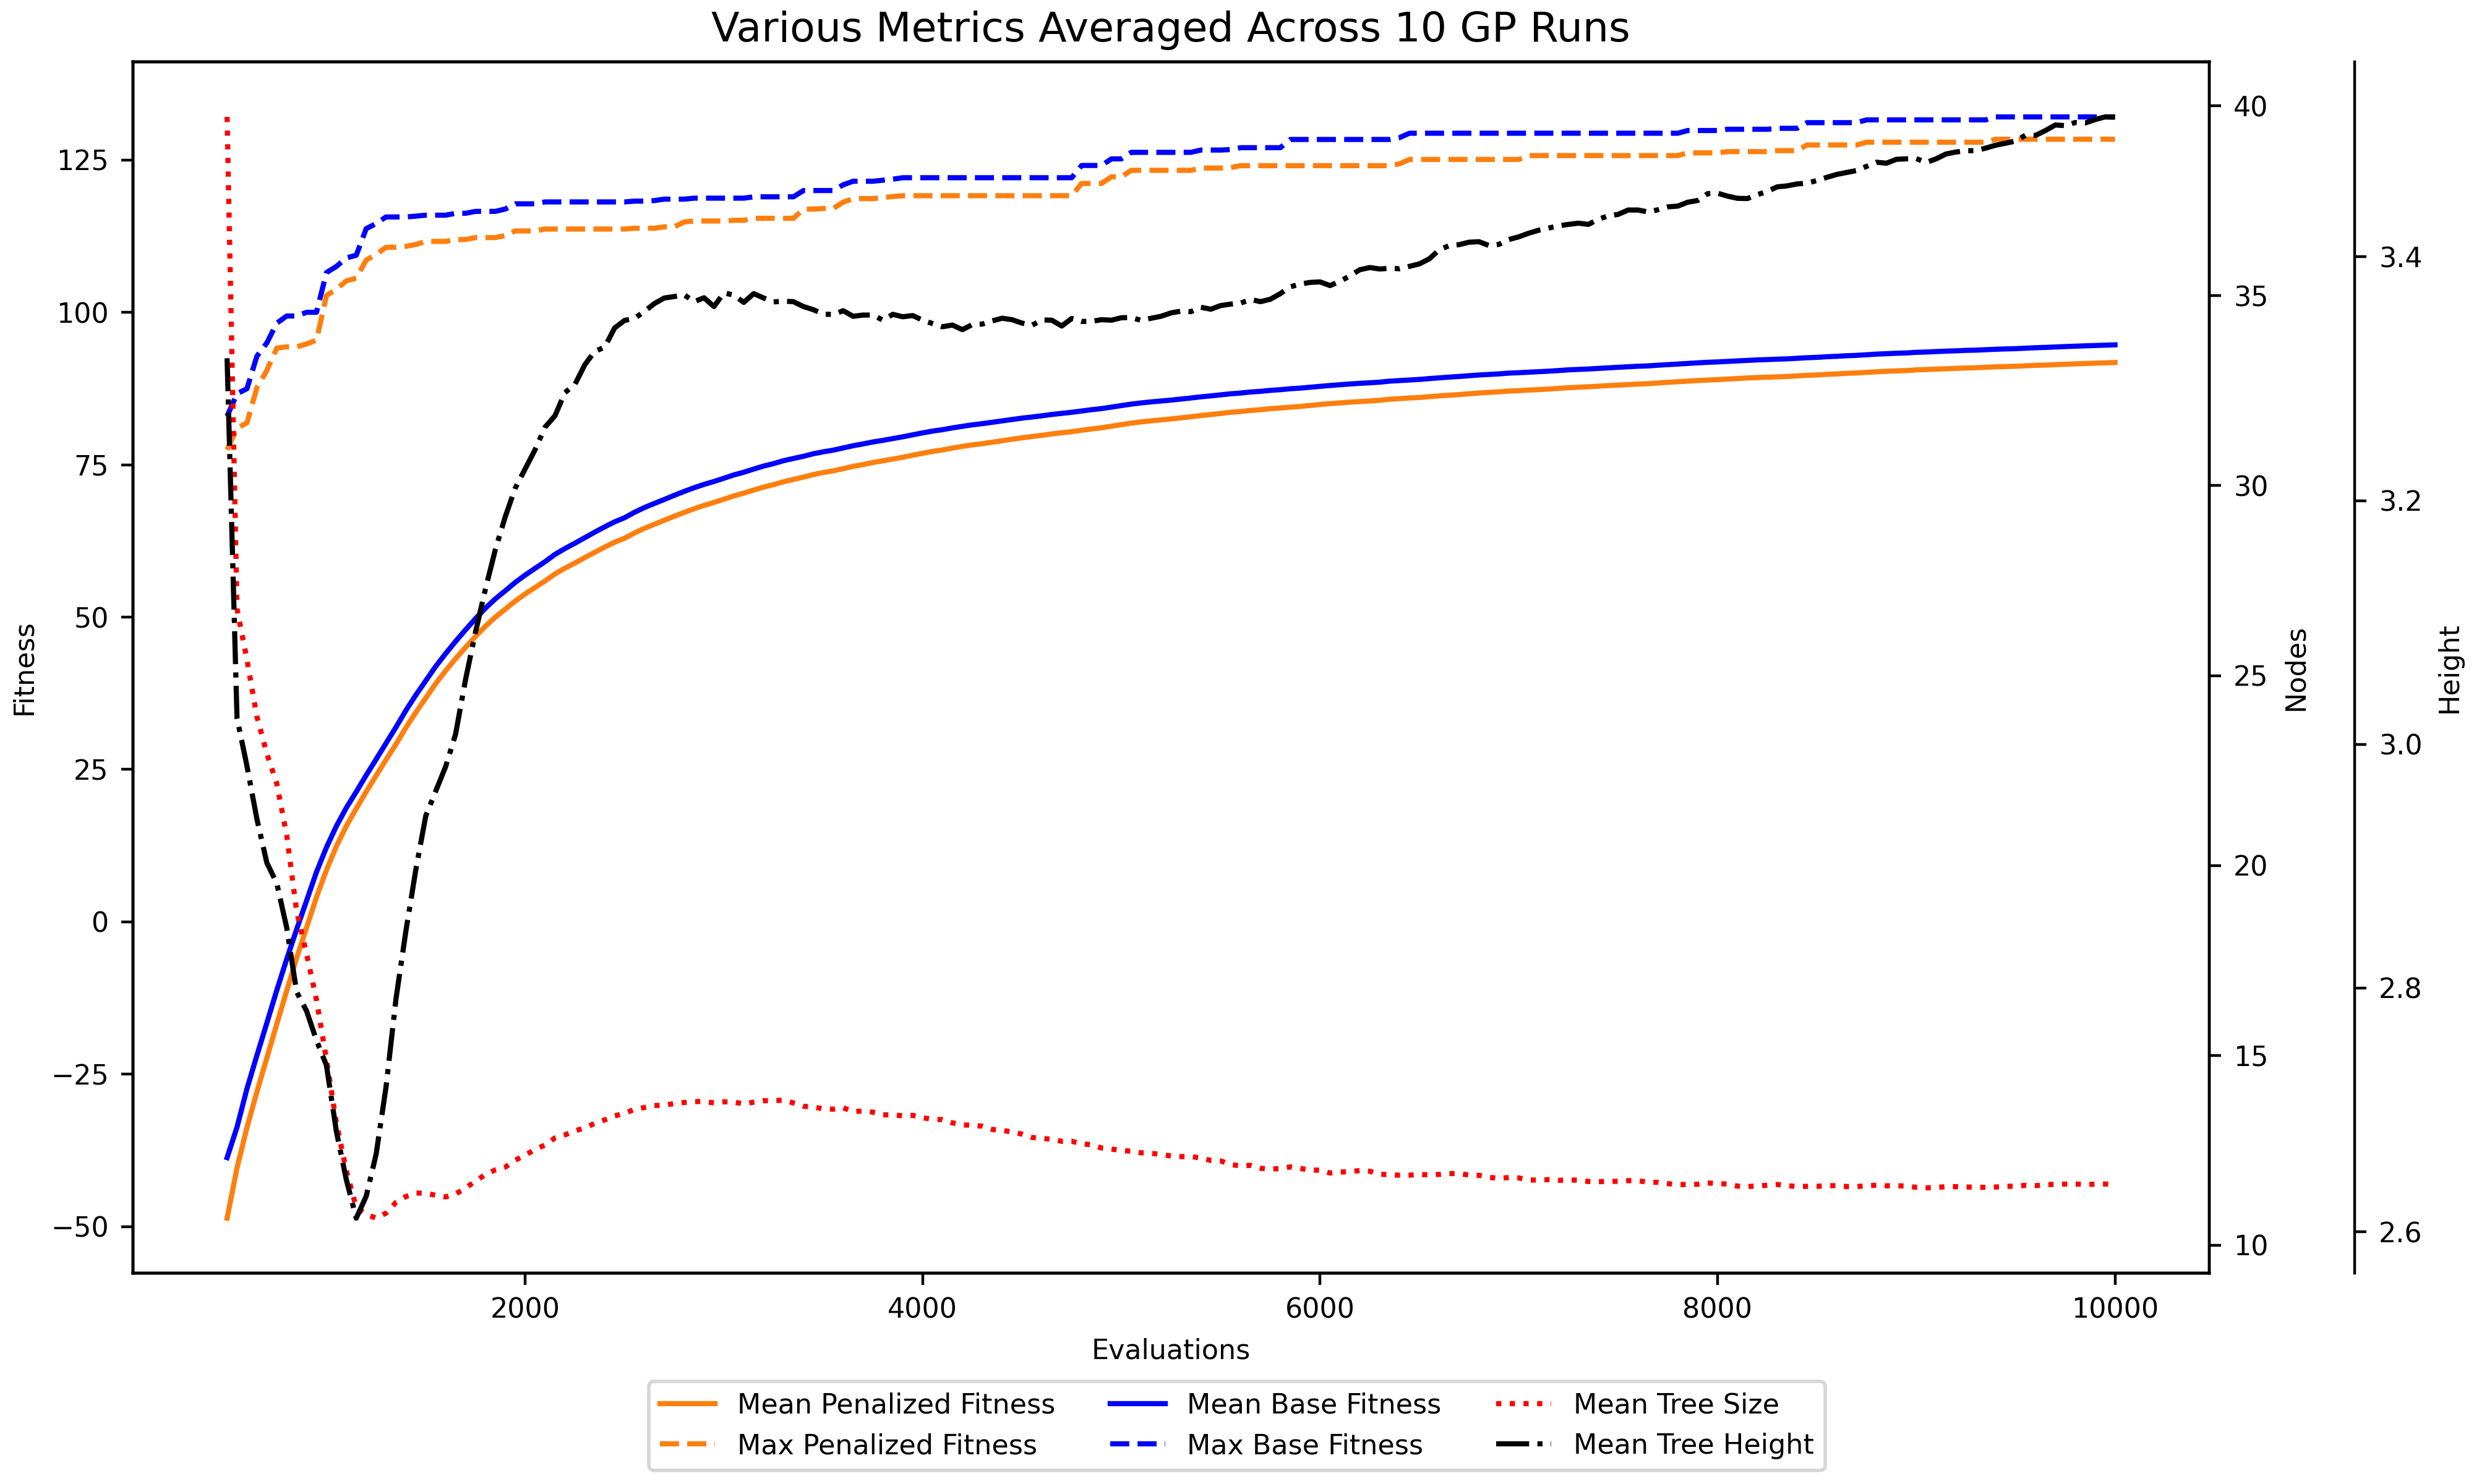

In the following cell, finish implementing the function to generate this plot from your data:

In [83]:
def evals_vs_fitness(mean_per_gen_per_run, max_per_gen_per_run, mean_base_per_gen_per_run, \
                     max_base_per_gen_per_run, mean_size_per_gen_per_run, \
                     mean_height_per_gen_per_run, evaluation_counts, title, filename):
    # Using the input mean_per_gen_per_run and max_per_gen_per_run values,
    # store the y-values for mean fitness in average_means,
    # and the y-values for best fitness in average_maxes.
    average_means = []
    average_maxes = []

    # This is similar to the above, but with the values for base fitness.
    average_base_means = []
    average_base_maxes = []

    # This is similar to the above, but with the values for mean size.
    average_size = []

    # This is similar to the above, but with the values for mean height.
    average_height = []

    for i in range(len(mean_per_gen_per_run[0])):

        # Create the lists of mean and max fitness values for gen i
        mean_gen_i_values = [mean_per_gen_per_run[j][i] for j in range(len(mean_per_gen_per_run))]
        max_gen_i_values = [max_per_gen_per_run[j][i] for j in range(len(max_per_gen_per_run))]
    
        # Find the average of the means and maxes and append them to their respective lists
        average_means.append(statistics.mean(mean_gen_i_values))
        average_maxes.append(statistics.mean(max_gen_i_values))
    
        # Create the lists of mean and max base fitness values for gen i
        mean_base_gen_i_values = [mean_base_per_gen_per_run[j][i] for j in range(len(mean_base_per_gen_per_run))]
        max_base_gen_i_values = [max_base_per_gen_per_run[j][i] for j in range(len(max_base_per_gen_per_run))]
    
        # Find the average of the means and maxes and append them to their respective lists
        average_base_means.append(statistics.mean(mean_base_gen_i_values))
        average_base_maxes.append(statistics.mean(max_base_gen_i_values))

        # Create the lists of mean size and height values for gen i
        mean_size_gen_i_values = [mean_size_per_gen_per_run[j][i] for j in range(len(mean_size_per_gen_per_run))]
        mean_height_gen_i_values = [mean_height_per_gen_per_run[j][i] for j in range(len(mean_height_per_gen_per_run))]
    
        # Find the average of the mean sizes and heights and append them to their respective lists
        average_size.append(statistics.mean(mean_size_gen_i_values))
        average_height.append(statistics.mean(mean_height_gen_i_values))

    
    # This will make the plot for you
    with plt.ioff():
        fig, ax = plt.subplots(figsize=(10.0, 6.0))
        ax.set(xlabel='Evaluations', title=title)
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax3.spines.right.set_position(('axes', 1.07))
        ax.plot(evaluation_counts, average_means, '-', color='tab:orange', label='Mean Penalized Fitness')
        ax.plot(evaluation_counts, average_maxes, '--', color='tab:orange', label='Max Penalized Fitness')
        ax.plot(evaluation_counts, average_base_means, 'b-', label='Mean Base Fitness')
        ax.plot(evaluation_counts, average_base_maxes, 'b--', label='Max Base Fitness')
        ax.set(ylabel='Fitness')
        ax2.plot(evaluation_counts, average_size, 'r:', label='Mean Tree Size')
        ax2.set(ylabel='Nodes')
        ax3.plot(evaluation_counts, average_height, 'k-.', label='Mean Tree Height')
        ax3.set(ylabel='Height')
        fig.legend(loc='outside lower center', ncols=3)
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
        fig.savefig(filename)
        fig.show()

With that function completed, run the following cell to generate your evals-vs-metrics plot. We'll save it to `data/2b/example/plot.png`, as well as display it. If you haven't modified the config, this plot may look a little strange; if the lines are mostly horizontal, that is completely fine. The x-axis will also end at the lower eval count that we used for this example. Still, you should double-check that the plot agrees with the data that you collected.

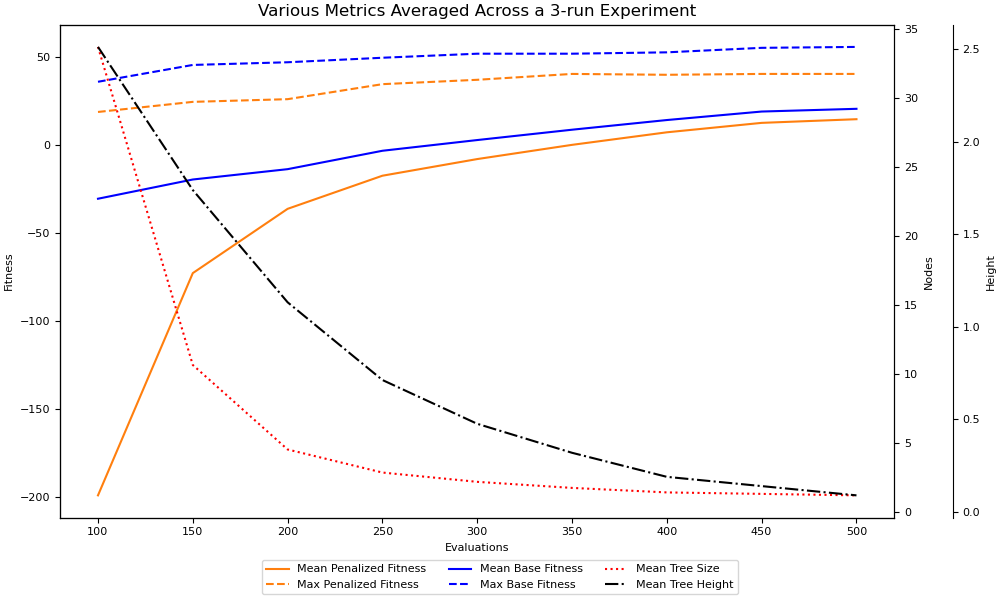

In [47]:
evals_vs_fitness(example_mean_per_gen_per_run,
                 example_max_per_gen_per_run,
                 example_mean_base_per_gen_per_run,
                 example_max_base_per_gen_per_run,
                 example_mean_size_per_gen_per_run,
                 example_mean_height_per_gen_per_run,
                 example_evaluation_counts,
                 'Various Metrics Averaged Across a 3-run Experiment',
                 'data/2b/example/plot.png')

Since you will be running many different experiments, we will define one more function to reduce boilerplate. This function encapsulates both running an experiment and saving all the necessary data.

In [84]:
def experiment_and_save(num_runs, num_evaluations, config, data_dir):
    (
        best_per_run,
        best_solution,
        mean_per_gen_per_run,
        max_per_gen_per_run,
        mean_base_per_gen_per_run,
        max_base_per_gen_per_run,
        mean_size_per_gen_per_run,
        mean_height_per_gen_per_run,
        evaluation_counts,
        hist,
        base_hist
    ) = gp_experiment(num_runs,
                      num_evaluations,
                      config)

    animation = save_data(best_per_run,
                          best_solution,
                          mean_per_gen_per_run,
                          max_per_gen_per_run,
                          mean_base_per_gen_per_run,
                          max_base_per_gen_per_run,
                          mean_size_per_gen_per_run,
                          mean_height_per_gen_per_run,
                          evaluation_counts,
                          hist,
                          base_hist,
                          data_dir,
                          config)
    
    fig = hist.get_plot(f'Distribution of Penalized Fitnesses Over {num_runs} GP Runs')
    fig.savefig(data_dir / 'histogram.png')
    fig.show()

    base_fig = base_hist.get_plot(f'Distribution of Base Fitnesses Over {num_runs} GP Runs')
    base_fig.savefig(data_dir / 'base_histogram.png')
    base_fig.show()
    
    evals_vs_fitness(mean_per_gen_per_run,
                     max_per_gen_per_run,
                     mean_base_per_gen_per_run,
                     max_base_per_gen_per_run,
                     mean_size_per_gen_per_run,
                     mean_height_per_gen_per_run,
                     evaluation_counts,
                     f'Various Metrics Averaged Across {num_runs} GP Runs',
                     data_dir / 'plot.png')

    return animation

## Tuning
As is the case with all EAs, tuning your GP algorithm is very important for good performance! In this case, it's also a graded component of the Algorithmic section of this assignment. Like Assignment 1b, **you are expected to tune your algorithm parameters such that your full GP search outperforms the random search conducted during Assignment 2a by a statistically-significant margin** (note that the default parameters are intentionally bad). As was the case with Assignment 1b, hand-tuning your parameters using a couple runs at a time is good enough for this class. While tuning, it can be helpful to ask yourself the following:
 * How many generations of evolution will occur based on $\mu$ and $\lambda$? Is this enough generations for evolution to find good solutions?
 * Is premature convergence occuring (e.g., max fitness stops increasing at a mediocre value)?
 * Is a loss of diversity preventing improvement (e.g., mean and best fitness quickly converge to very similar values)?
 * Have the problem instance or search space parameters been manipulated in a way that invalidates a comparison with your random search (i.e., avoid manipulating the game parameters and tree depth limits)?
 * Is the parsimony coefficient tuned well? (Note: you'll need to consider this explicitly if attempting the YELLOW deliverable)

As usual, the following cell defines a function to make tuning convenient:

In [85]:
def tuning_experiment(num_runs, num_evaluations, config_path):
    config = read_config(config_path, globals(), locals())
    config_text = config_path.read_text()

    # Set up a new subdirectory for us to save artifacts to
    base_subdir = Path('./tuning/') / config_path.parent.name / config_path.stem
    base_subdir.mkdir(parents=True, exist_ok=True)
    children = set(int(child.stem) for child in base_subdir.iterdir())
    if children:
        index = max(children) + 1
    else:
        index = 1
    subdir = base_subdir / str(index)

    # Run your GP experiment and save the data
    animation = experiment_and_save(num_runs, num_evaluations, config, subdir)

    # Make a copy of the config
    config_copy = subdir / config_path.name
    config_copy.write_text(config_path.read_text())

    # Print average best base fitness
    with open(subdir / 'best_per_run.txt', 'r') as f:
        best_per_run = [float(line) for line in f.readlines()]
    print('Average best base fitness:', statistics.mean(best_per_run))

    return animation

Now, tune the parameters in `configs/2b/green_config.txt` (including `parsimony_coefficient`).

Note that the parsimony coefficient can be any positive real number. If you want to use a non-integer coefficient, we strongly recommend writing it as a rational fraction: you should use 1/3 rather than 0.333333, to help avoid floating-point errors.

In [ ]:
tuning_runs = 5 # Note you can increase this with no time loss if you have more CPU cores
num_evaluations = 10_000
green_config_path = Path('./configs/2b/green_config.txt')

animation = tuning_experiment(tuning_runs, num_evaluations, green_config_path)
display(HTML(animation))

## Running Your Experiment
With your tuning complete, you can execute the following cell to run your full experiment!

Data saved to data/2b/green


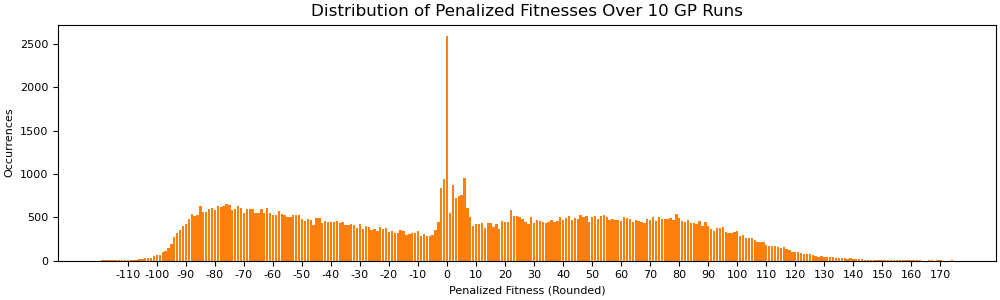

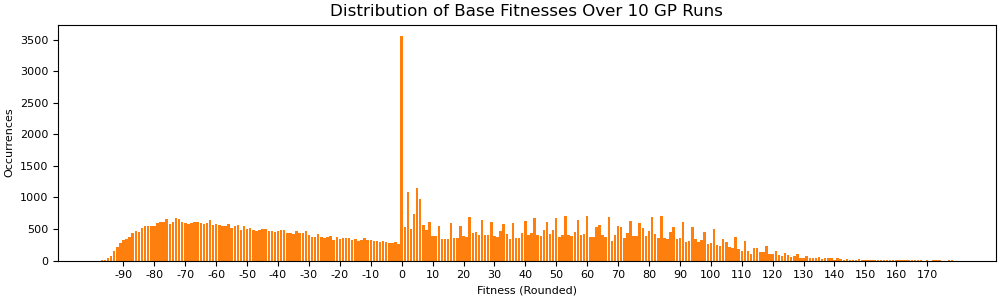

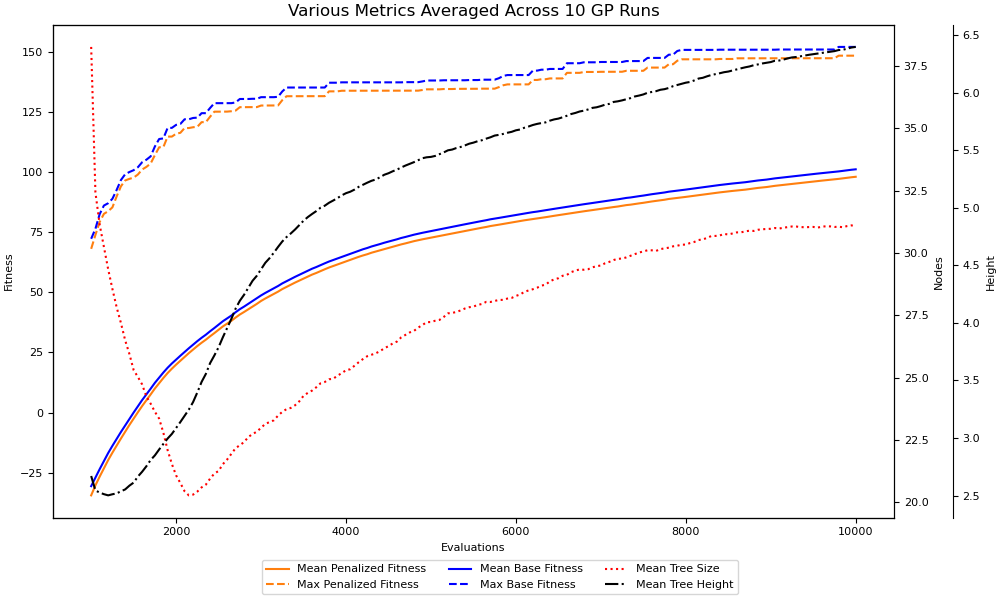

In [88]:
num_runs = 10
num_evaluations = 10_000
green_config = read_config('configs/2b/green_config.txt', globals(), locals())
green_data_path = Path('./data/2b/green/')

animation = experiment_and_save(num_runs,
                                num_evaluations,
                                green_config,
                                green_data_path)

Run the following cell to watch the best game.

In [ ]:
display(HTML(animation))

## Report
Now you should have the data required to complete the report described in the assignment document. There are components of the report you need to complete independently, but you should conduct your statistical analysis in the following cell, comparing your best per-run **base** fitness from this experiment to your best per-run scores from Assignment 2a. You should look back at Assignment Series 1 for examples of how to do this.

In [90]:
from stats import run_stats
# TODO: Conduct statistical analysis comparing the results of 2a and 2b

run_stats('data/2a/green/best_per_run.txt', 'data/2b/green/best_per_run.txt')

Number of samples: 10
data/2a/green/best_per_run.txt mean: 114.25413067552603
data/2a/green/best_per_run.txt stdv: 13.366695919511455
data/2b/green/best_per_run.txt mean: 151.9455149501661
data/2b/green/best_per_run.txt stdv: 14.44259448318582
p-value: 1.0294028051803898e-05


# YELLOW Experiment (Required for 6660, bonus for 5660)

This assignment's YELLOW deliverable requires you to treat parsimony pressure as a multiobjective problem, rather than as a penalty function. That is, you should use multiobjective code (similar to what you implemented in Assignment 1d) aiming to maximize game score, while minimizing your chosen parsimony metric. Keep in mind all of the nuances involved in writing multiobjective code, as highlighted in Assignment 1d.

In addition, in order to observe how this multiobjective algorithm behaves differently from your GREEN experiment, you should conduct a "control" experiment which generates all the same visualizations as your YELLOW experiment, but which uses a penalty function for parsimony pressure (i.e., your GREEN experiment but with more data collected). If you already collected that data while running your GREEN experiment, you can simply use those results. Otherwise, you will need to add the relevant data collection and then run another experiment.

Use the following cells to implement, tune, and conduct a 10-run experiment (and a control experiment, if necessary). You may add more cells, if necessary. **Do not overwrite or break compatibility with your previous experimentation**.

# Fitness Sharing RED Deliverable (Bonus)
This assignment's RED 1 deliverable requires you to implement fitness sharing. We have provided a decent amount of the required logic for this, so you don't need to worry about coming up with a distance metric. There are two important things you need to understand here:

1. In your population evaluation function, you should add the keyword `score_vector=True` to your `play_GPac` function call. This will cause the function to return a third value in addition to the score and game log, which is a vector representing how the score was calculated. You should store this as the member variable `score_vector` on every `TreeGenotype` you evaluate.
2. For the distance between two individuals, use Euclidean distance in the space of these score vectors. i.e., the distance between two individuals `A` and `B` is the Euclidean distance between `A.score_vector` and `B.score_vector`.

There are also five important things to change about your existing evolution code:

1. `base_fitness` is unchanged, but `fitness` now represents the penalized fitness after applying both the parsimony penalty and the fitness sharing penalty. This is calculated by **first subtracting the parsimony penalty**, *then* **dividing the fitness according to fitness sharing**. This order of operations is very important.
2. You need to re-calculate fitness sharing after every change to the population, much like how you needed to re-sort individuals in Assignment 1d. **You must NOT re-evaluate individuals** (by playing more games of GPac), but you do need to re-calculate their penalized fitness via fitness sharing.
3. For data collection, you should calculate the *average pairwise distance* across the entire adult population at the end of each generation (including the initial population). The code for calculating this is provided for you, in the `pairwise_sharing` function in the following cell. This represents how diverse your population is in this space. You will use this value to compare against your GREEN experiment.
4. You must add sigma and alpha (the parameters for fitness sharing) to a new deliverable-specific config, and tune them appropriately.
5. You do not need to generate histograms.

Use the following cells to implement, tune, and conduct a 10-run experiment. You may add more cells, if necessary. **Do not overwrite or break compatibility with your previous experimentation**.

In [ ]:
def pairwise_sharing(population):
    n = len(population)
    total = 0
    for i in range(n):
        for j in range(i+1, n):
            total += sqrt(sum(i_o**2 - j_o**2 for i_o, j_o in zip(population[i].score_vector, population[j].score_vector)))
    return total / (n * (n - 1) / 2)

# Other RED Deliverables (Bonus)
Bonus RED deliverables are typically somewhat open-ended, but this is particularly true in Assignment Series 2. As such, you may encounter unanticipated design decisions and obstacles that you should figure out how to overcome. TA assistance is available to answer questions, though you are expected to experiment and investigate solutions/answers prior to seeking this assistance. You are welcome to re-use tuned parameters between these experiments instead of conducting more rigorous tuning, though you may observe more interesting results with per-deliverable tuning.

For each RED deliverable you attempt, **do not overwrite or break compatibility with your previous experimentation**: create a new notebook cell below, create a new config file, and implement the relevant section in the `base_population_evaluation` function.

# Side Note: Canonical Genetic Programming
Should you apply GP after this class, you should know that the GP algorithm taught in this class (as described in the course textbook) differs somewhat from the algorithm canonically used in GP. Notably, the textbook has certain important omissions regarding the Ramped Half-and-half algorithm and the GP evolutionary cycle. In practice, the Ramped Half-and-half algorithm uses a `grow` method which ensures at least 1 branch reaches the depth limit. This can be difficult to implement, and has little impact on this assignment, so we don't require the implementation of the canonical version of the algorithm.

More importantly, however, is that the canonical GP evolutionary cycle is generational in nature. In the canonical Generational GP algorithm, $\mu$ children are created each generation via recombination, mutation, or *reproduction* and the children directly replace the parents without survival selection. Notably, the reproduction operation involves directly copying the selected parent to the children pool and this enables behavior similar to the steady-state survival of a $(\mu + \lambda)$-EA. The algorithm you implement for this assignment series is much more similar to a Genetic Algorithm in nature and you should be aware of this distinction if you continue to work with GP. For more information, see [here](https://geneticprogramming.com/about-gp/gp-workflow/).